In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

print(f"TensorFlow version: {tf.__version__}")

from src_numpy import (
    particle_filter_numpy,
    make_random_walk_ssm_np,
    make_range_bearing_ssm_np,
)

from src.filters import (
    kalman_filter,
    ekf_filter,
    ukf_filter
)

TensorFlow version: 2.20.0


In [3]:
# Model 1: Random walk
ssm = make_random_walk_ssm_np(Q=0.2, R=0.5)
xs, ys = ssm.simulate(T=200, seed=42)
ms, Ps, info = particle_filter_numpy(ssm, ys, num_particles=1000, seed=123)

# Model 3: Range-bearing
ssm_rb = make_range_bearing_ssm_np(dt=0.01, q_diag=0.01, nu=2.0, s_r=0.01, s_th=0.01)
xs, ys = ssm_rb.simulate(T=100, seed=42)
ms, Ps, info = particle_filter_numpy(ssm_rb, ys, num_particles=5000, seed=123)

In [4]:
# NumPy PF vs TensorFlow KF (1D Random Walk)

def test_random_walk_np_vs_tf_kf(T=200, Q=0.2, R=0.5, m0=0.3, P0=1.2, 
                                   num_particles=10000, seed=42):
    """
    Compare NumPy PF against TensorFlow KF for 1D random walk.
    """
    dtype = tf.float64
    
    # --- Create NumPy SSM and simulate ---
    ssm_np = make_random_walk_ssm_np(Q=Q, R=R, m0=m0, P0=P0)
    xs_np, ys_np = ssm_np.simulate(T=T, seed=seed)
    
    # --- Run NumPy PF ---
    start = time.time()
    ms_pf, Ps_pf, info_pf = particle_filter_numpy(
        ssm_np, ys_np, num_particles=num_particles, seed=seed+1
    )
    time_np = time.time() - start
    print(f"NumPy PF time: {time_np:.3f}s")
    
    # --- Run TF KF ---
    ys_tf = tf.convert_to_tensor(ys_np, dtype=dtype)
    A_tf = tf.constant([[1.0]], dtype=dtype)
    C_tf = tf.constant([[1.0]], dtype=dtype)
    B_tf = tf.constant([[np.sqrt(Q)]], dtype=dtype)  # BB^T = Q
    D_tf = tf.constant([[np.sqrt(R)]], dtype=dtype)  # DD^T = R
    m0_tf = tf.constant([m0], dtype=dtype)
    P0_tf = tf.constant([[P0]], dtype=dtype)
    
    start = time.time()
    ms_kf, Ps_kf = kalman_filter(
        ys_tf, A_tf, B_tf, C_tf, D_tf, m0_tf, P0_tf, eps=0.0, dtype=dtype
    )
    time_kf = time.time() - start
    print(f"TF KF time: {time_kf:.3f}s")
    
    ms_kf_np = ms_kf.numpy()
    Ps_kf_np = Ps_kf.numpy()
    
    mean_abs_err = np.mean(np.abs(ms_pf - ms_kf_np))
    max_abs_err = np.max(np.abs(ms_pf - ms_kf_np))
    max_rel_err = np.max(np.abs(ms_pf - ms_kf_np) / (np.abs(ms_kf_np) + 1e-12))
    
    print(f"\n--- Results (N={num_particles}) ---")
    print(f"Mean abs error: {mean_abs_err:.4e}")
    print(f"Max abs error:  {max_abs_err:.4e}")
    print(f"Max rel error:  {max_rel_err:.4e}")
    print(f"Avg ESS:        {np.mean(info_pf['ess']/num_particles):.1f}")
    
    return ms_pf, Ps_pf, ms_kf_np, Ps_kf_np, info_pf


ms_pf, Ps_pf, ms_kf, Ps_kf, info = test_random_walk_np_vs_tf_kf(
    T=200, num_particles=10**6, seed=42
)

NumPy PF time: 14.312s
TF KF time: 0.190s

--- Results (N=1000000) ---
Mean abs error: 5.5825e-04
Max abs error:  3.1865e-03
Max rel error:  8.2812e-02
Avg ESS:        0.6


RMSE (NumPy PF): 0.4310
RMSE (TF KF):    0.4309


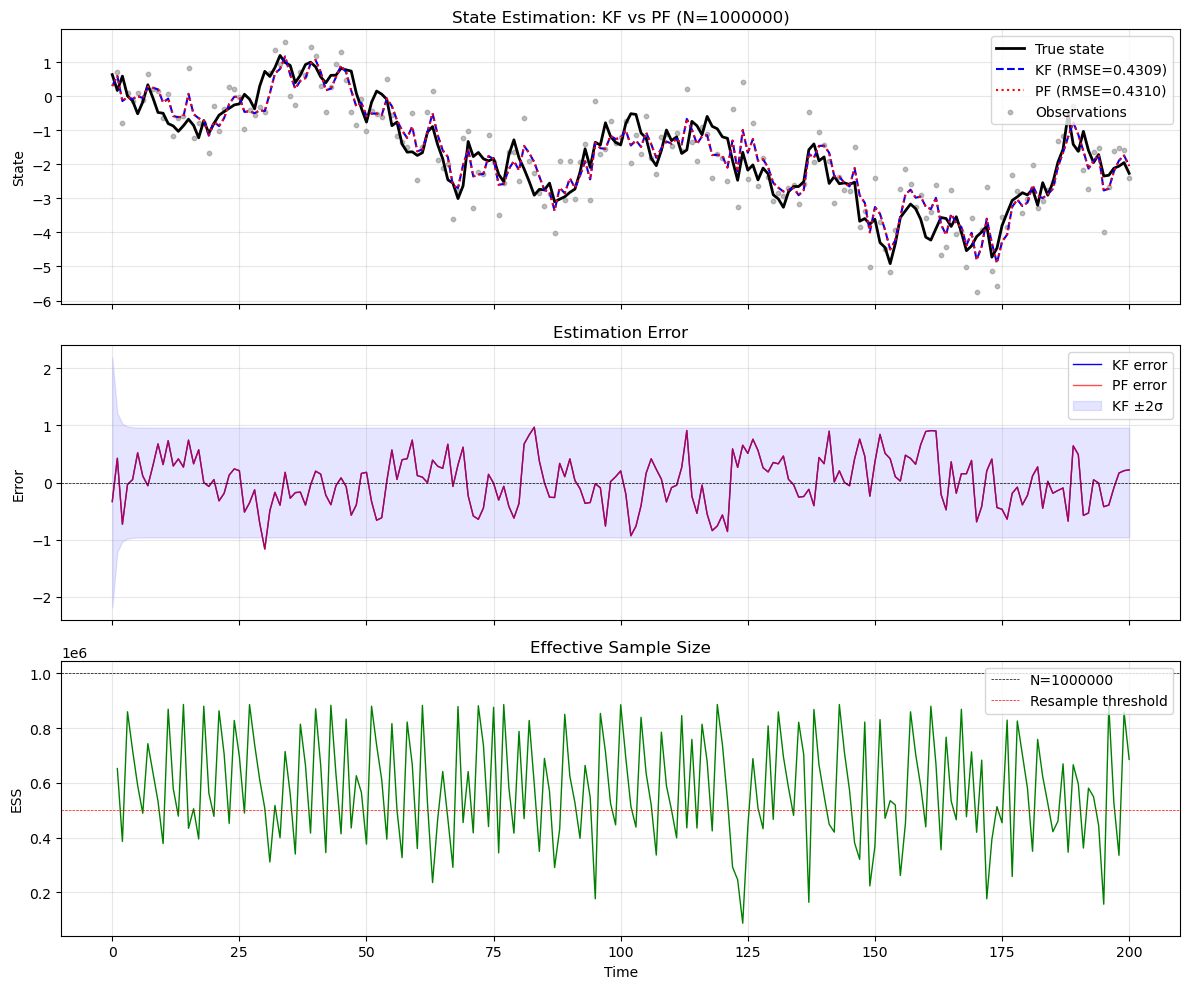

In [5]:
def test_visualize_and_rmse(T=200, Q=0.2, R=0.5, m0=0.3, P0=1.2,
                             num_particles=10000, seed=42):
    """
    Compare KF and NumPy PF estimates visually and compute RMSE.
    """
    dtype = tf.float64
    
    ssm_np = make_random_walk_ssm_np(Q=Q, R=R, m0=m0, P0=P0)
    xs_true, ys_np = ssm_np.simulate(T=T, seed=seed)
    
    ms_pf, Ps_pf, info_pf = particle_filter_numpy(
        ssm_np, ys_np, num_particles=num_particles, seed=seed+1
    )
    
    ys_tf = tf.convert_to_tensor(ys_np, dtype=dtype)
    A_tf = tf.constant([[1.0]], dtype=dtype)
    C_tf = tf.constant([[1.0]], dtype=dtype)
    B_tf = tf.constant([[np.sqrt(Q)]], dtype=dtype)
    D_tf = tf.constant([[np.sqrt(R)]], dtype=dtype)
    m0_tf = tf.constant([m0], dtype=dtype)
    P0_tf = tf.constant([[P0]], dtype=dtype)
    
    ms_kf, Ps_kf = kalman_filter(
        ys_tf, A_tf, B_tf, C_tf, D_tf, m0_tf, P0_tf, eps=0.0, dtype=dtype
    )
    ms_kf = ms_kf.numpy()
    Ps_kf = Ps_kf.numpy()
    
    rmse_pf = np.sqrt(np.mean((ms_pf - xs_true) ** 2))
    rmse_kf = np.sqrt(np.mean((ms_kf - xs_true) ** 2))
    
    print(f"RMSE (NumPy PF): {rmse_pf:.4f}")
    print(f"RMSE (TF KF):    {rmse_kf:.4f}")
    
    std_pf = np.sqrt(Ps_pf[:, 0, 0])
    std_kf = np.sqrt(Ps_kf[:, 0, 0])
    
    t = np.arange(T + 1)
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    ax1 = axes[0]
    ax1.plot(t, xs_true[:, 0], 'k-', lw=2, label='True state')
    ax1.plot(t, ms_kf[:, 0], 'b--', lw=1.5, label=f'KF (RMSE={rmse_kf:.4f})')
    ax1.plot(t, ms_pf[:, 0], 'r:', lw=1.5, label=f'PF (RMSE={rmse_pf:.4f})')
    ax1.scatter(t[1:], ys_np[:, 0], s=10, c='gray', alpha=0.5, label='Observations')
    ax1.set_ylabel('State')
    ax1.set_title(f'State Estimation: KF vs PF (N={num_particles})')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[1]
    err_kf = ms_kf[:, 0] - xs_true[:, 0]
    err_pf = ms_pf[:, 0] - xs_true[:, 0]
    ax2.plot(t, err_kf, 'b-', lw=1, label='KF error')
    ax2.plot(t, err_pf, 'r-', lw=1, alpha=0.7, label='PF error')
    ax2.axhline(0, color='k', lw=0.5, ls='--')
    ax2.fill_between(t, -2*std_kf, 2*std_kf, color='blue', alpha=0.1, label='KF ±2σ')
    ax2.set_ylabel('Error')
    ax2.set_title('Estimation Error')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    ax3 = axes[2]
    ax3.plot(np.arange(1, T+1), info_pf['ess'], 'g-', lw=1)
    ax3.axhline(num_particles, color='k', lw=0.5, ls='--', label=f'N={num_particles}')
    ax3.axhline(0.5 * num_particles, color='r', lw=0.5, ls='--', label='Resample threshold')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('ESS')
    ax3.set_title('Effective Sample Size')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return xs_true, ms_pf, ms_kf, info_pf


xs_true, ms_pf, ms_kf, info = test_visualize_and_rmse(
    T=200, num_particles=10**6, seed=42
)

RMSE (position): 0.0369
RMSE (velocity): 0.6927
RMSE (total):    0.4905
Avg ESS:         36.2 / 1000


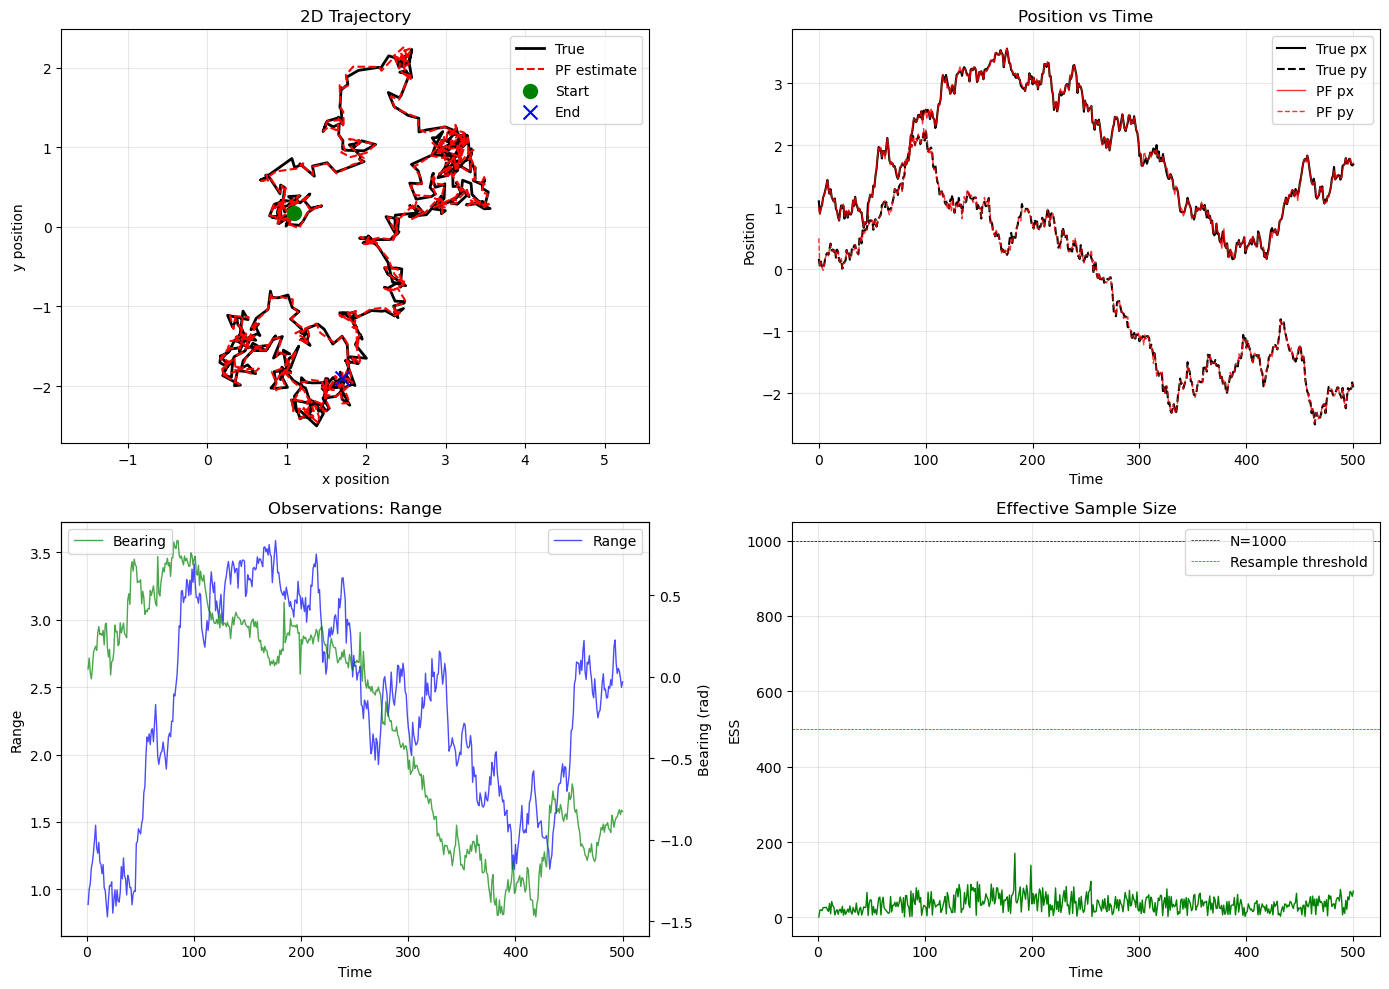

In [6]:
def test_range_bearing_visualization(T=500, num_particles=1000, seed=42):
    """
    Visualize Range-Bearing tracking: True states vs PF estimate.
    """
    ssm_rb = make_range_bearing_ssm_np(
        dt=0.01, q_diag=0.01, nu=2.0, s_r=0.01, s_th=0.01
    )
    xs_true, ys_np = ssm_rb.simulate(T=T, seed=seed)
    
    ms_pf, Ps_pf, info_pf = particle_filter_numpy(
        ssm_rb, ys_np, num_particles=num_particles, seed=seed+1
    )
    
    # State: [px, py, vx, vy]
    rmse_pos = np.sqrt(np.mean((ms_pf[:, :2] - xs_true[:, :2]) ** 2))
    rmse_vel = np.sqrt(np.mean((ms_pf[:, 2:] - xs_true[:, 2:]) ** 2))
    rmse_total = np.sqrt(np.mean((ms_pf - xs_true) ** 2))
    
    print(f"RMSE (position): {rmse_pos:.4f}")
    print(f"RMSE (velocity): {rmse_vel:.4f}")
    print(f"RMSE (total):    {rmse_total:.4f}")
    print(f"Avg ESS:         {np.mean(info_pf['ess']):.1f} / {num_particles}")
    
    fig = plt.figure(figsize=(14, 10))
    
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(xs_true[:, 0], xs_true[:, 1], 'k-', lw=2, label='True')
    ax1.plot(ms_pf[:, 0], ms_pf[:, 1], 'r--', lw=1.5, label='PF estimate')
    ax1.scatter(xs_true[0, 0], xs_true[0, 1], c='g', s=100, marker='o', label='Start', zorder=5)
    ax1.scatter(xs_true[-1, 0], xs_true[-1, 1], c='b', s=100, marker='x', label='End', zorder=5)
    ax1.set_xlabel('x position')
    ax1.set_ylabel('y position')
    ax1.set_title('2D Trajectory')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')

    ax2 = fig.add_subplot(2, 2, 2)
    t = np.arange(T + 1)
    ax2.plot(t, xs_true[:, 0], 'k-', lw=1.5, label='True px')
    ax2.plot(t, xs_true[:, 1], 'k--', lw=1.5, label='True py')
    ax2.plot(t, ms_pf[:, 0], 'r-', lw=1, alpha=0.8, label='PF px')
    ax2.plot(t, ms_pf[:, 1], 'r--', lw=1, alpha=0.8, label='PF py')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Position')
    ax2.set_title('Position vs Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    ax3 = fig.add_subplot(2, 2, 3)
    t_obs = np.arange(1, T + 1)
    ax3.plot(t_obs, ys_np[:, 0], 'b-', lw=1, alpha=0.7, label='Range')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Range')
    ax3.set_title('Observations: Range')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    ax3b = ax3.twinx()
    ax3b.plot(t_obs, ys_np[:, 1], 'g-', lw=1, alpha=0.7, label='Bearing')
    ax3b.set_ylabel('Bearing (rad)')
    ax3b.legend(loc='upper left')
    
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.plot(t_obs, info_pf['ess'], 'g-', lw=1)
    ax4.axhline(num_particles, color='k', lw=0.5, ls='--', label=f'N={num_particles}')
    ax4.axhline(0.5 * num_particles, color='r', lw=0.5, ls='--', label='Resample threshold')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('ESS')
    ax4.set_title('Effective Sample Size')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return xs_true, ys_np, ms_pf, Ps_pf, info_pf

xs_true, ys_rb, ms_pf, Ps_pf, info_pf = test_range_bearing_visualization(
    T=500, num_particles=1000, seed=42
)

=== RMSE Comparison ===
Method     |   Position |      Total
-----------------------------------
PF         |     0.0419 |     0.4555
EKF        |     0.0726 |     0.4762
UKF        |     0.0725 |     0.4762

PF particles: 1000, Avg ESS: 38.4


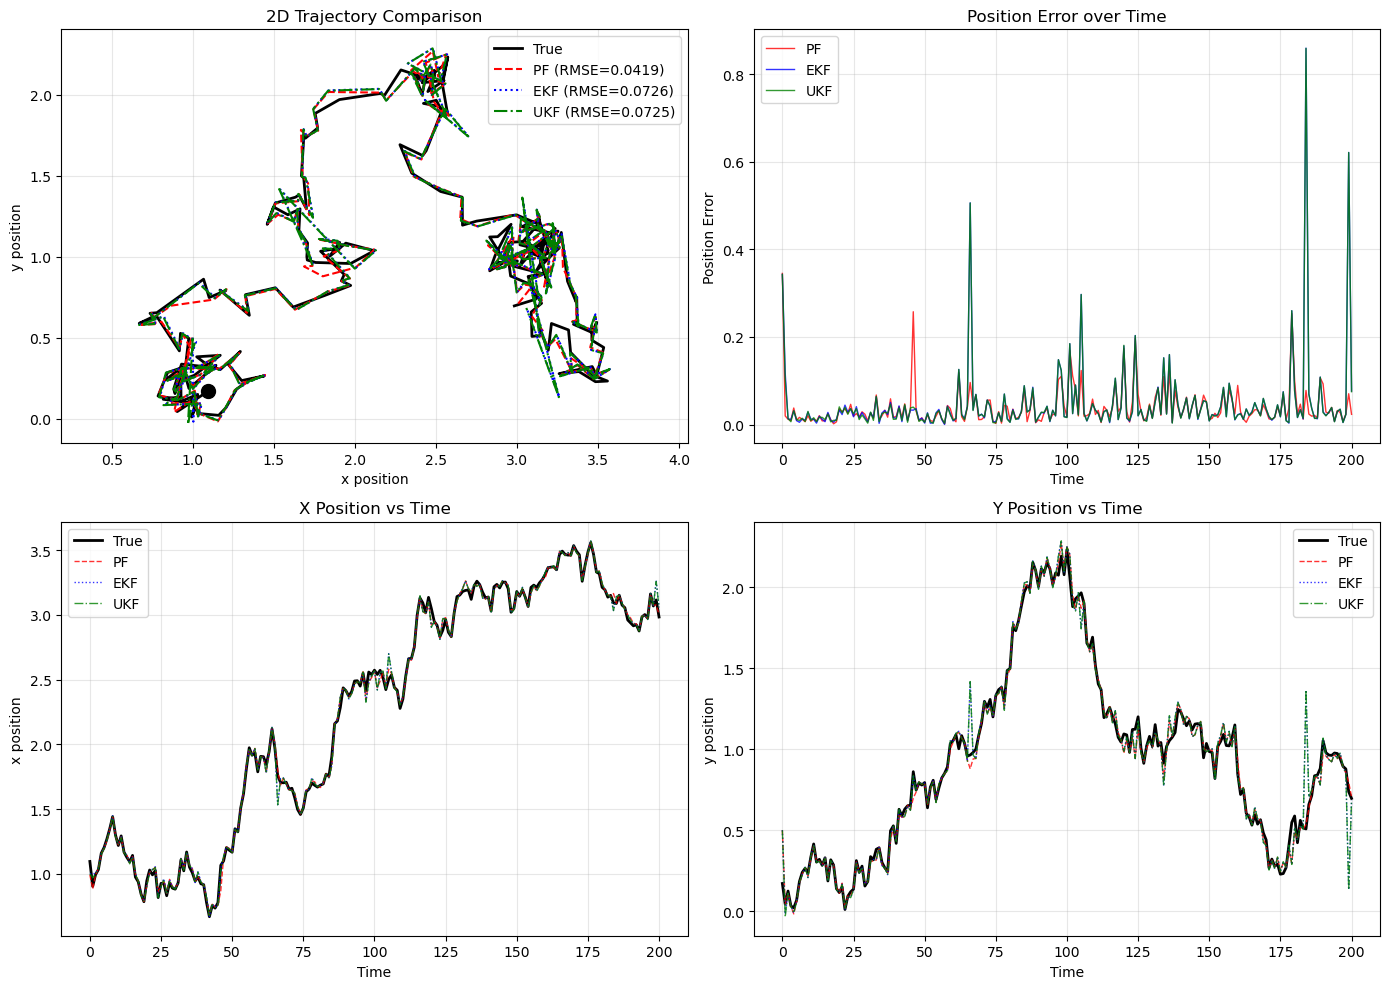

In [8]:
def test_range_bearing_pf_vs_ekf_ukf(T=200, num_particles=1000, seed=42):
    """
    Compare NumPy PF vs TF EKF/UKF for Range-Bearing model.
    """
    dtype = tf.float64
    
    dt = 0.01
    q_diag = 0.01
    nu = 2.0
    s_r = 0.01
    s_th = 0.01
    m0_tuple = (1.0, 0.5, 0.01, 0.01)
    P0_diag_tuple = (0.1, 0.1, 0.1, 0.1)
    
    ssm_np = make_range_bearing_ssm_np(
        dt=dt, q_diag=q_diag, nu=nu, s_r=s_r, s_th=s_th,
        m0=m0_tuple, P0_diag=P0_diag_tuple
    )
    xs_true, ys_np = ssm_np.simulate(T=T, seed=seed)
    
    ms_pf, Ps_pf, info_pf = particle_filter_numpy(
        ssm_np, ys_np, num_particles=num_particles, seed=seed+1
    )

    ys_tf = tf.convert_to_tensor(ys_np, dtype=dtype)
    
    # Model parameters for EKF/UKF
    nx = 4
    A = np.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ])
    Q = np.diag(np.full(nx, q_diag))

    R = np.diag([s_r**2, s_th**2])
    
    m0 = np.array(m0_tuple)
    P0 = np.diag(np.array(P0_diag_tuple))
    
    A_tf = tf.constant(A, dtype=dtype)
    Q_tf = tf.constant(Q, dtype=dtype)
    R_tf = tf.constant(R, dtype=dtype)
    m0_tf = tf.constant(m0, dtype=dtype)
    P0_tf = tf.constant(P0, dtype=dtype)
    
    def f(x, u, t):
        return tf.linalg.matvec(A_tf, x)
    
    def F_jac(x, u, t):
        return A_tf
    
    def h(x, t):
        px, py = x[0], x[1]
        r = tf.sqrt(px**2 + py**2 + 1e-12)
        th = tf.atan2(py, px)
        return tf.stack([r, th])
    
    def H_jac(x, t):
        px, py = x[0], x[1]
        r2 = px**2 + py**2 + 1e-12
        r = tf.sqrt(r2)
        
        dr_dpx = px / r
        dr_dpy = py / r
        dth_dpx = -py / r2
        dth_dpy = px / r2
        
        row0 = tf.stack([dr_dpx, dr_dpy, 0.0, 0.0])
        row1 = tf.stack([dth_dpx, dth_dpy, 0.0, 0.0])
        return tf.stack([row0, row1])
    

    ms_ekf, Ps_ekf = ekf_filter(
        ys_tf, f, F_jac, h, H_jac, Q_tf, R_tf, m0_tf, P0_tf,
        u_seq=None, eps=1e-6, dtype=dtype
    )
    ms_ekf = ms_ekf.numpy()
    Ps_ekf = Ps_ekf.numpy()
    

    ms_ukf, Ps_ukf = ukf_filter(
        ys_tf, f, h, Q_tf, R_tf, m0_tf, P0_tf,
        u_seq=None, eps=1e-6, dtype=dtype
    )
    ms_ukf = ms_ukf.numpy()
    Ps_ukf = Ps_ukf.numpy()
    
    rmse_pf = np.sqrt(np.mean((ms_pf - xs_true) ** 2))
    rmse_ekf = np.sqrt(np.mean((ms_ekf - xs_true) ** 2))
    rmse_ukf = np.sqrt(np.mean((ms_ukf - xs_true) ** 2))
    
    rmse_pf_pos = np.sqrt(np.mean((ms_pf[:, :2] - xs_true[:, :2]) ** 2))
    rmse_ekf_pos = np.sqrt(np.mean((ms_ekf[:, :2] - xs_true[:, :2]) ** 2))
    rmse_ukf_pos = np.sqrt(np.mean((ms_ukf[:, :2] - xs_true[:, :2]) ** 2))
    
    print("=== RMSE Comparison ===")
    print(f"{'Method':<10} | {'Position':>10} | {'Total':>10}")
    print("-" * 35)
    print(f"{'PF':<10} | {rmse_pf_pos:>10.4f} | {rmse_pf:>10.4f}")
    print(f"{'EKF':<10} | {rmse_ekf_pos:>10.4f} | {rmse_ekf:>10.4f}")
    print(f"{'UKF':<10} | {rmse_ukf_pos:>10.4f} | {rmse_ukf:>10.4f}")
    print(f"\nPF particles: {num_particles}, Avg ESS: {np.mean(info_pf['ess']):.1f}")
    
    fig = plt.figure(figsize=(14, 10))
    
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(xs_true[:, 0], xs_true[:, 1], 'k-', lw=2, label='True')
    ax1.plot(ms_pf[:, 0], ms_pf[:, 1], 'r--', lw=1.5, label=f'PF (RMSE={rmse_pf_pos:.4f})')
    ax1.plot(ms_ekf[:, 0], ms_ekf[:, 1], 'b:', lw=1.5, label=f'EKF (RMSE={rmse_ekf_pos:.4f})')
    ax1.plot(ms_ukf[:, 0], ms_ukf[:, 1], 'g-.', lw=1.5, label=f'UKF (RMSE={rmse_ukf_pos:.4f})')
    ax1.scatter(xs_true[0, 0], xs_true[0, 1], c='k', s=100, marker='o', zorder=5)
    ax1.set_xlabel('x position')
    ax1.set_ylabel('y position')
    ax1.set_title('2D Trajectory Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    ax2 = fig.add_subplot(2, 2, 2)
    t = np.arange(T + 1)
    err_pf = np.sqrt(np.sum((ms_pf[:, :2] - xs_true[:, :2])**2, axis=1))
    err_ekf = np.sqrt(np.sum((ms_ekf[:, :2] - xs_true[:, :2])**2, axis=1))
    err_ukf = np.sqrt(np.sum((ms_ukf[:, :2] - xs_true[:, :2])**2, axis=1))
    
    ax2.plot(t, err_pf, 'r-', lw=1, alpha=0.8, label='PF')
    ax2.plot(t, err_ekf, 'b-', lw=1, alpha=0.8, label='EKF')
    ax2.plot(t, err_ukf, 'g-', lw=1, alpha=0.8, label='UKF')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Position Error')
    ax2.set_title('Position Error over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(t, xs_true[:, 0], 'k-', lw=2, label='True')
    ax3.plot(t, ms_pf[:, 0], 'r--', lw=1, alpha=0.8, label='PF')
    ax3.plot(t, ms_ekf[:, 0], 'b:', lw=1, alpha=0.8, label='EKF')
    ax3.plot(t, ms_ukf[:, 0], 'g-.', lw=1, alpha=0.8, label='UKF')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('x position')
    ax3.set_title('X Position vs Time')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.plot(t, xs_true[:, 1], 'k-', lw=2, label='True')
    ax4.plot(t, ms_pf[:, 1], 'r--', lw=1, alpha=0.8, label='PF')
    ax4.plot(t, ms_ekf[:, 1], 'b:', lw=1, alpha=0.8, label='EKF')
    ax4.plot(t, ms_ukf[:, 1], 'g-.', lw=1, alpha=0.8, label='UKF')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('y position')
    ax4.set_title('Y Position vs Time')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'xs_true': xs_true,
        'ys': ys_np,
        'ms_pf': ms_pf,
        'ms_ekf': ms_ekf,
        'ms_ukf': ms_ukf,
        'rmse': {'pf': rmse_pf, 'ekf': rmse_ekf, 'ukf': rmse_ukf},
        'rmse_pos': {'pf': rmse_pf_pos, 'ekf': rmse_ekf_pos, 'ukf': rmse_ukf_pos},
        'info_pf': info_pf,
    }


# Run comparison test
results = test_range_bearing_pf_vs_ekf_ukf(T=200, num_particles=1000, seed=42)